In [39]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from pathlib import Path
from going_modular import data_setup
from going_modular.engine import train_step, test_step
from going_modular.utils import save_model
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torchinfo import summary
from datetime import datetime
import os
from going_modular.predictions import pred_and_plot_image


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device : {device}")

using device : cuda


In [3]:
def set_seeds(seed:int=42):
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    print(f"using seed : {seed}")

In [4]:
set_seeds()

using seed : 42


In [5]:
image_path = Path("./data/pizza_steak_sushi")

In [6]:
# create dataloaders using manualy created transforms

train_dir = image_path / "train"
test_dir = image_path / "test"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1291307b390>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# create DataLoaders using automatically created transforms

train_dir = image_path / "train"
test_dir = image_path / "test"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1291308f390>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# download the pretrained weights for efficientnet_b0

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [13]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [14]:
summary(model, 
        input_size=(1, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer

In [17]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Experiment Tracking
        
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        writer.add_graph(model=model, 
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    writer.close()

    return results

In [18]:
set_seeds()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

using seed : 42


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0783 | train_acc: 0.4414 | test_loss: 0.8777 | test_acc: 0.7434


 20%|██        | 1/5 [00:51<03:27, 51.88s/it]

Epoch: 2 | train_loss: 0.9210 | train_acc: 0.6641 | test_loss: 0.7843 | test_acc: 0.7633


 40%|████      | 2/5 [01:38<02:27, 49.06s/it]

Epoch: 3 | train_loss: 0.7544 | train_acc: 0.7656 | test_loss: 0.6609 | test_acc: 0.8655


 60%|██████    | 3/5 [02:23<01:34, 47.16s/it]

Epoch: 4 | train_loss: 0.6852 | train_acc: 0.8789 | test_loss: 0.6539 | test_acc: 0.8655


 80%|████████  | 4/5 [03:07<00:45, 45.96s/it]

Epoch: 5 | train_loss: 0.7134 | train_acc: 0.7344 | test_loss: 0.6856 | test_acc: 0.7633


100%|██████████| 5/5 [03:53<00:00, 46.67s/it]


In [19]:
# view model results with tensorboard

# %load_ext tensorboard
# %tensorboard --logdir=runs

In [20]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    

    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [21]:
writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
writer

[INFO] Created SummaryWriter, saving to: runs\2025-03-10\data_10_percent\effnetb0\5_epochs...


In [22]:
import torch.utils.tensorboard


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
  
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # Experiment Tracking
        
        if writer:
            writer.add_scalars(main_tag="Loss", 
                            tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                            global_step=epoch)

            writer.add_scalars(main_tag="Accuracy", 
                            tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                            global_step=epoch)
            
            writer.add_graph(model=model, 
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
        
            writer.close()
        else:
            pass

    return results

In [23]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

In [24]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [25]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [26]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: using the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

In [27]:
# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [29]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [30]:
# EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [31]:
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [32]:
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [33]:
effnetb0 = create_effnetb0() 
effnetb2 = create_effnetb2()

using seed : 42
[INFO] Created new effnetb0 model.
using seed : 42
[INFO] Created new effnetb2 model.


In [34]:
num_epochs = [5]
models = ["effnetb0", "effnetb2"]
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [35]:
%%time

set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():

    for epochs in num_epochs: 

        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            if model_name == "effnetb0":
                model = create_effnetb0() 
            else:
                model = create_effnetb2() 
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

using seed : 42
[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
using seed : 42
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-03-10\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0674 | train_acc: 0.4688 | test_loss: 0.9316 | test_acc: 0.4574


 20%|██        | 1/5 [01:06<04:27, 66.83s/it]

Epoch: 2 | train_loss: 0.9451 | train_acc: 0.5469 | test_loss: 0.8445 | test_acc: 0.5900


 40%|████      | 2/5 [02:04<03:04, 61.44s/it]

Epoch: 3 | train_loss: 0.8312 | train_acc: 0.6797 | test_loss: 0.7328 | test_acc: 0.8040


 60%|██████    | 3/5 [02:55<01:53, 56.86s/it]

Epoch: 4 | train_loss: 0.7303 | train_acc: 0.7617 | test_loss: 0.6306 | test_acc: 0.8864


 80%|████████  | 4/5 [03:48<00:55, 55.32s/it]

Epoch: 5 | train_loss: 0.6066 | train_acc: 0.8906 | test_loss: 0.5877 | test_acc: 0.8968


100%|██████████| 5/5 [04:47<00:00, 57.42s/it]


[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
using seed : 42
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2025-03-10\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0991 | train_acc: 0.3438 | test_loss: 0.9524 | test_acc: 0.7017


 20%|██        | 1/5 [01:09<04:39, 69.80s/it]

Epoch: 2 | train_loss: 0.9002 | train_acc: 0.6328 | test_loss: 0.8941 | test_acc: 0.6922


 40%|████      | 2/5 [02:09<03:12, 64.00s/it]

Epoch: 3 | train_loss: 0.8646 | train_acc: 0.6562 | test_loss: 0.8062 | test_acc: 0.7746


 60%|██████    | 3/5 [03:06<02:01, 60.73s/it]

Epoch: 4 | train_loss: 0.7126 | train_acc: 0.8672 | test_loss: 0.6991 | test_acc: 0.9176


 80%|████████  | 4/5 [04:00<00:57, 57.91s/it]

Epoch: 5 | train_loss: 0.7023 | train_acc: 0.7305 | test_loss: 0.6502 | test_acc: 0.8968


100%|██████████| 5/5 [04:53<00:00, 58.78s/it]


[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
using seed : 42
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-03-10\data_20_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9674 | train_acc: 0.5625 | test_loss: 0.6694 | test_acc: 0.8759


 20%|██        | 1/5 [00:56<03:47, 56.84s/it]

Epoch: 2 | train_loss: 0.6926 | train_acc: 0.8104 | test_loss: 0.5806 | test_acc: 0.8968


 40%|████      | 2/5 [01:51<02:46, 55.60s/it]

Epoch: 3 | train_loss: 0.5862 | train_acc: 0.8417 | test_loss: 0.5112 | test_acc: 0.8873


 60%|██████    | 3/5 [02:45<01:49, 54.93s/it]

Epoch: 4 | train_loss: 0.4727 | train_acc: 0.8854 | test_loss: 0.4109 | test_acc: 0.9176


 80%|████████  | 4/5 [03:37<00:53, 53.72s/it]

Epoch: 5 | train_loss: 0.4464 | train_acc: 0.8562 | test_loss: 0.3928 | test_acc: 0.9280


100%|██████████| 5/5 [04:32<00:00, 54.50s/it]


[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
using seed : 42
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2025-03-10\data_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9775 | train_acc: 0.5563 | test_loss: 0.7724 | test_acc: 0.8153


 20%|██        | 1/5 [00:54<03:39, 54.96s/it]

Epoch: 2 | train_loss: 0.7173 | train_acc: 0.8021 | test_loss: 0.6527 | test_acc: 0.8665


 40%|████      | 2/5 [01:52<02:49, 56.56s/it]

Epoch: 3 | train_loss: 0.5676 | train_acc: 0.8896 | test_loss: 0.5465 | test_acc: 0.9384


 60%|██████    | 3/5 [02:49<01:53, 56.82s/it]

Epoch: 4 | train_loss: 0.5214 | train_acc: 0.8187 | test_loss: 0.5059 | test_acc: 0.9176


 80%|████████  | 4/5 [03:44<00:56, 56.16s/it]

Epoch: 5 | train_loss: 0.4598 | train_acc: 0.8688 | test_loss: 0.4485 | test_acc: 0.9489


100%|██████████| 5/5 [04:40<00:00, 56.13s/it]


[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

CPU times: total: 4min 16s
Wall time: 18min 58s


In [36]:
best_model_path = "./models/07_effnetb2_data_20_percent_5_epochs.pth"

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))

using seed : 42
[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [37]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


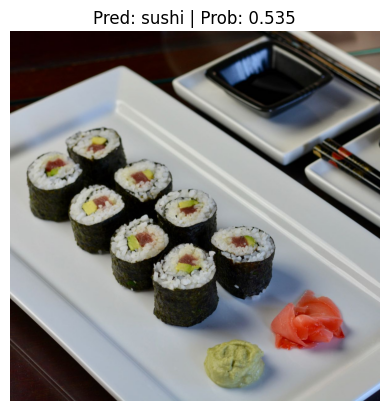

In [42]:
pred_and_plot_image(model=best_model,
                    image_path="./images/sushi.jpg",
                    class_names=class_names,
                    )